In [14]:
#import necessary packages
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import seaborn as sns
import numpy as np

import scanpy.api as sc

import scipy
scipy.__version__

'1.2.2'

In [15]:
path='/Users/derekbogdanoff/projects/XYZeq/data/20190917/'

In [16]:
sc.settings.verbosity=3
sc.settings.set_figure_params(dpi=80)
sc.logging.print_versions()
results_file = './write/results.h5ad'

#sc.settings = True

##load the data
adata=sc.read(path + 'matrix_mergedIntron.mtx', cache=False).T





# ##name the genes
adata.var_names = [gene.strip() for gene in open(path + 'genes.tsv', 'r')]


# ##name the cells
adata.obs_names = [barcode.strip() for barcode in open(path + 'barcodes.tsv', 'r')] 




scanpy==1.4.3 anndata==0.6.21 umap==0.3.9 numpy==1.17.2 scipy==1.2.2 pandas==0.23.4 scikit-learn==0.19.2 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [17]:
adata.var_names_make_unique()

In [18]:
adata=adata[adata.obs_names.str.contains('L20C1')]

In [19]:
##post processing filter minimum UMIS and genes
sc.pp.filter_cells(adata, min_counts=500)#300
sc.pp.filter_cells(adata, min_genes=100)

#sc.pp.filter_cells(adata, max_counts=15000)
#sc.pp.filter_cells(adata, max_genes=2000) 

##post processing filter genes 
sc.pp.filter_genes(adata, min_cells=2)
#sc.pp.filter_genes(adata, max_cells=1000)   

## define mito genes 
mito_genes=[name for name in adata.var_names if name.startswith(('mm10_mt-', 'hg19_mt-', 'mt-'))]


##create new obs anotation to define percent mito for each cell 
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)*100

##create new obs anotation to define UMIs per cell
adata.obs['n_counts'] = adata.X.sum(axis=1)



Trying to set attribute `.obs` of view, making a copy.


filtered out 18293 cells that have less than 500 counts
filtered out 3 cells that have less than 100 genes expressed
filtered out 71226 genes that are detected in less than 2 cells


In [20]:
spec_filter= [name for name in adata.var_names if not name.startswith('mm10_Itgam')]
adata=adata[:, spec_filter]

In [21]:
spec_filter= [name for name in adata.var_names if not name.startswith('mm10_Smim20')]
adata=adata[:, spec_filter]

In [22]:
spec_filter= [name for name in adata.var_names if not name.startswith('hg19_RP11-323I15.5')]
adata=adata[:, spec_filter]

In [23]:
##filter out outliers

adata = adata[adata.obs['n_genes'] < 15000, :]
adata = adata[adata.obs['n_counts'] < 10000, :]
adata = adata[adata.obs['percent_mito'] < 1, :]


In [24]:
##create raw data file

adata.raw = sc.pp.log1p(adata, copy=True)




In [25]:
##normalize counts per cell to 10K each 

sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)



In [26]:
print(adata.X.sum(axis=1))

[[10000.   ]
 [ 9999.999]
 [ 9999.999]
 ...
 [10000.   ]
 [10000.   ]
 [10000.002]]


In [27]:
adata.shape

(4788, 50241)

In [28]:

filter_result = sc.pp.filter_genes_dispersion(
    adata.X, min_mean=0.35, max_mean=7, min_disp=1) ####L20C1 parameters 

    
    
sc.pl.filter_genes_dispersion(filter_result)


In [29]:
sum(filter_result.gene_subset)

789

In [30]:
#percent of genes that are highly variable
sum(filter_result.gene_subset)/len(filter_result.gene_subset)*100

1.570430524870126

In [31]:
adata = adata[:, filter_result.gene_subset]

In [32]:
sc.pp.log1p(adata)

In [33]:
#Regress out unwanted sources of variation
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:04.14)


In [34]:
sc.pp.scale(adata, max_value=10)

In [35]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA with n_comps = 50
    finished (0:00:00.63)


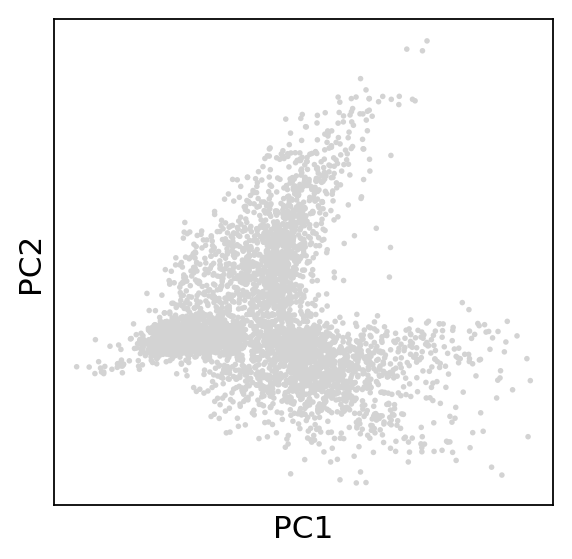

In [36]:
sc.pl.pca(adata)

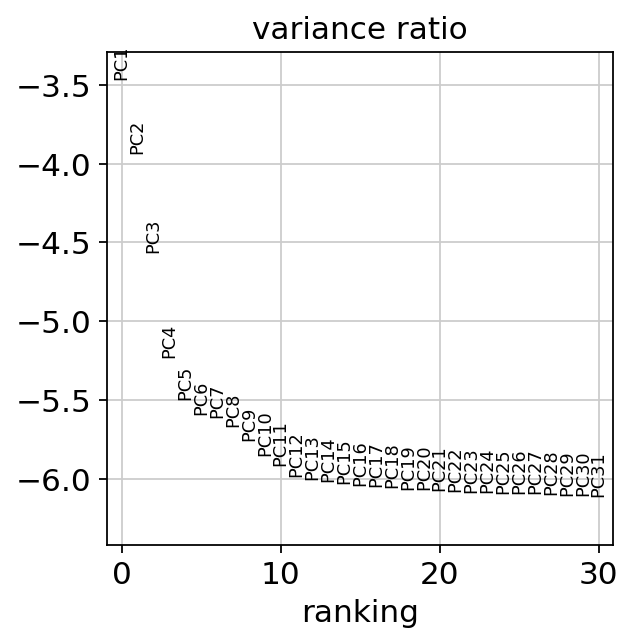

In [37]:
sc.pl.pca_variance_ratio(adata, log=True)

In [38]:
sc.pp.neighbors(adata, n_neighbors=12, n_pcs=10)

computing neighbors
    using 'X_pca' with n_pcs = 10


/Users/derekbogdanoff/projects/venv3/lib/python3.7/site-packages/umap/umap_.py:349: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../../../venv3/lib/python3.7/site-packages/umap/umap_.py", line 467:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^

  @numba.jit()
/Users/derekbogdanoff/projects/venv3/lib/python3.7/site-packages/numba/compiler.py:725: NumbaWarning: Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.

File "../../../venv3/lib/python3.7/site-packages/umap/umap_.py", line 350:
@numba.jit()
def fuzzy_simplicial_set(
^

  self.func_ir.loc))
/Users/derekbogdanoff/projects/venv3/lib/python3.7/site-packages/numba/compiler.py:734: NumbaDep

    finished (0:00:02.75) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix


In [39]:
sc.tl.leiden(adata, resolution=0.6)

running Leiden clustering
    finished (0:00:00.66) --> found 11 clusters and added
    'leiden', the cluster labels (adata.obs, categorical)


In [40]:
sc.tl.louvain(adata, resolution=0.8)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.40) --> found 13 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


In [41]:
sc.tl.umap(adata,
            min_dist=.1,
            spread=2,
            alpha=2,
            )

computing UMAP
    using 'X_pca' with n_pcs = 10
    finished (0:00:07.72) --> added
    'X_umap', UMAP coordinates (adata.obsm)


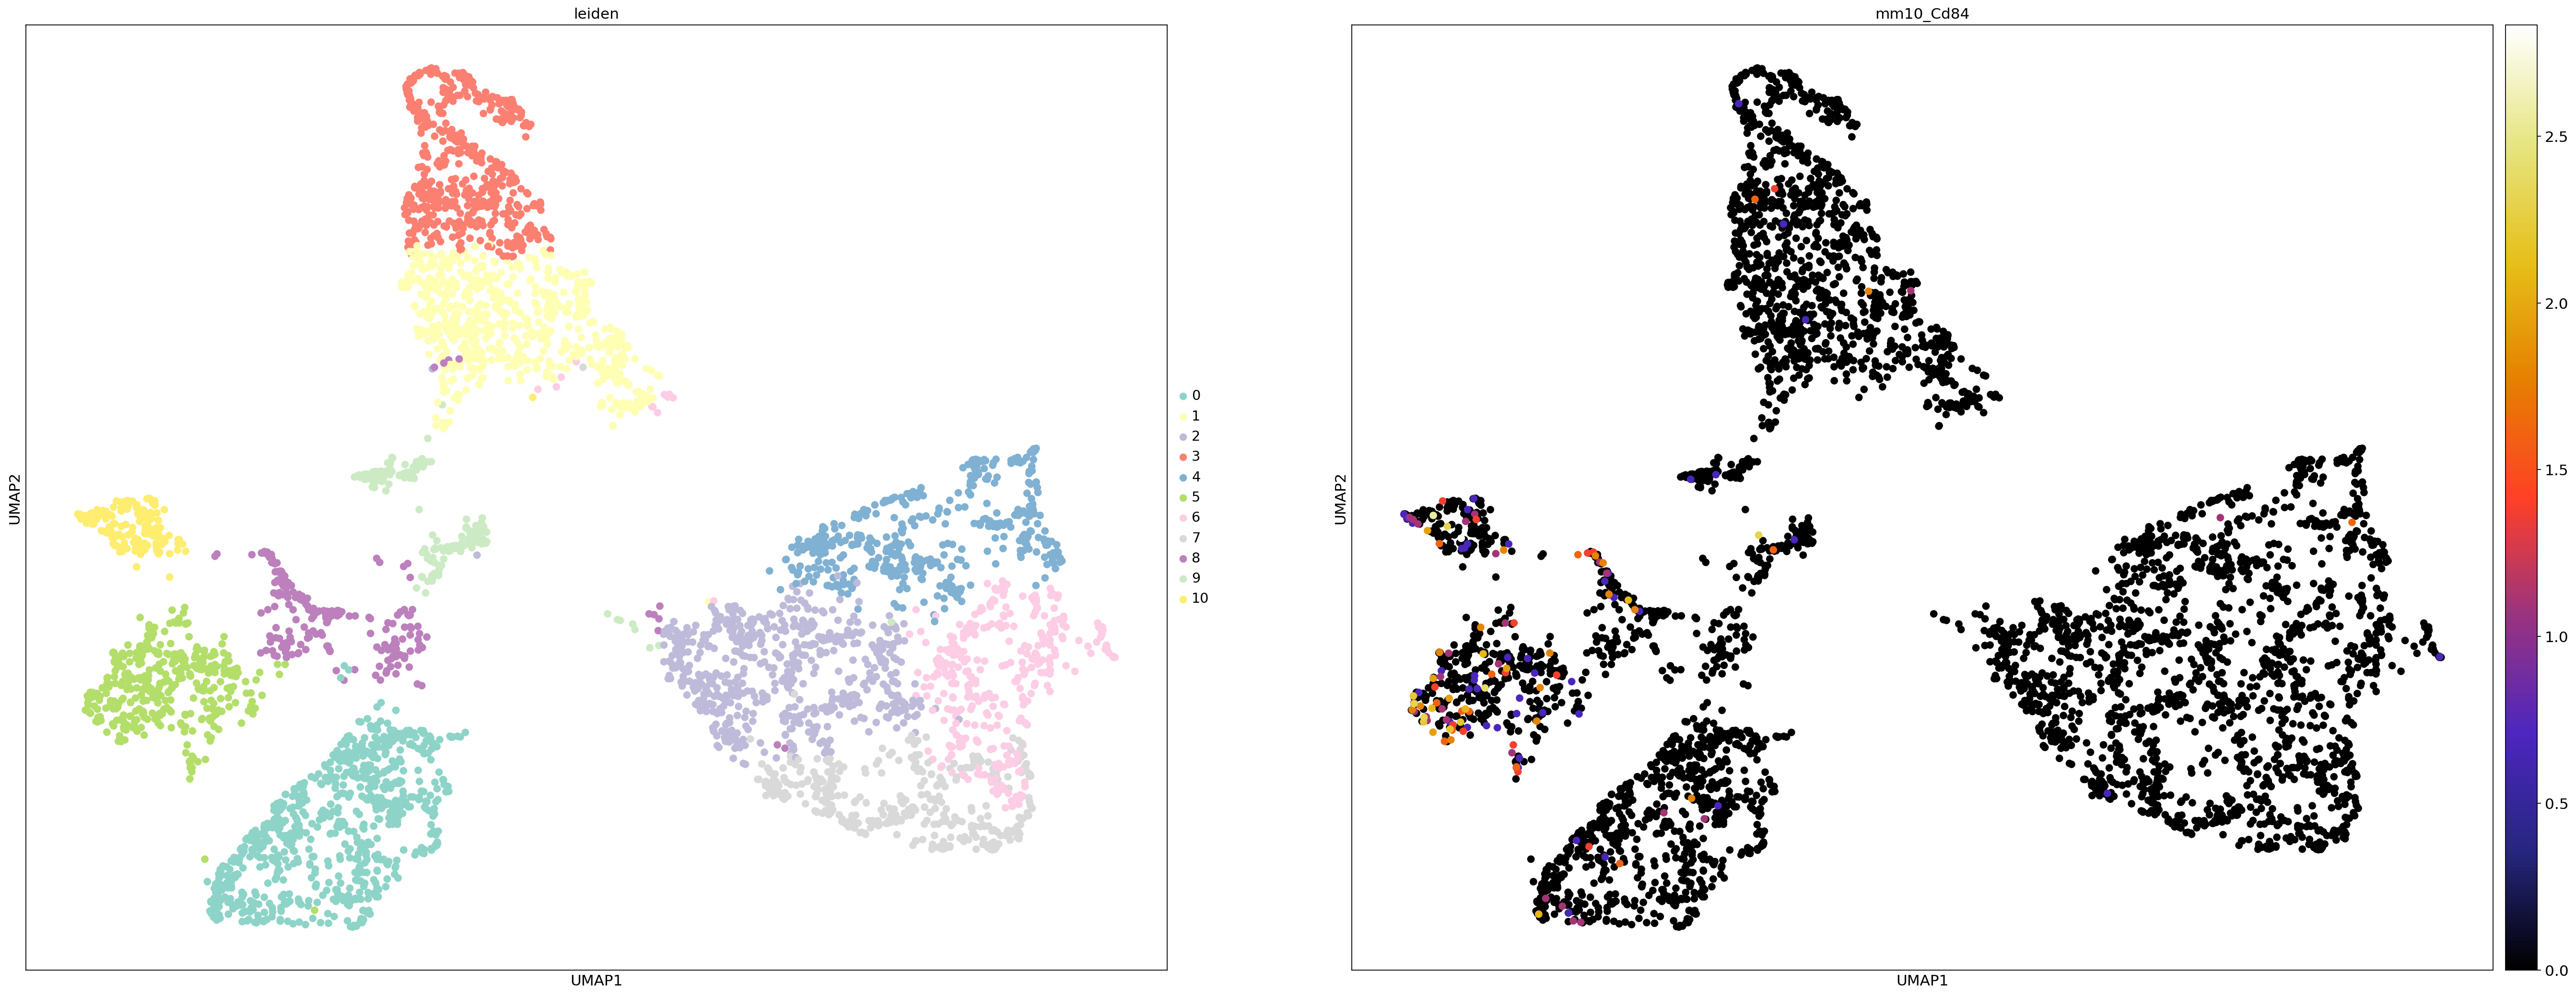

In [42]:
plt.rcParams['figure.figsize'] = [20, 16]

sc.pl.umap(adata, 
           color=['leiden','mm10_Cd84'],
           ncols=4,
           palette="Set3",
           color_map=mpl.cm.CMRmap,
      #     legend_loc='on data',
           size=200)

In [43]:
### define new annotation for celltype based on leiden clusters ####

cell_type_df=pd.DataFrame(adata.obs['leiden'])


def label (row):
   if row['leiden'] == '0':
      return 'mc38'
   if row['leiden'] =='1':
      return 'Hepatocyte'
   if row['leiden'] == '2':
      return 'Hek293t'
   if row['leiden'] == '3':
      return 'Hepatocyte'
   if row['leiden']  == '4':
      return 'Hek293t'
   if row['leiden'] == '5':
      return 'Macrophage'
   if row['leiden'] == '6':
      return 'Hek293t'
   if row['leiden'] == '7':
      return 'Hek293t'
   if row['leiden'] == '8':
      return 'Lymphocyte'
   if row['leiden'] == '9':
      return 'LSEC'
   if row['leiden'] == '10':    
      return 'Kupffer'
    
    
cell_type_df_ =  pd.DataFrame(cell_type_df.apply (lambda row: label(row), axis=1),)

cell_type_df_.columns=['CellType']

adata.obs['CellType']=cell_type_df_



... storing 'CellType' as categorical


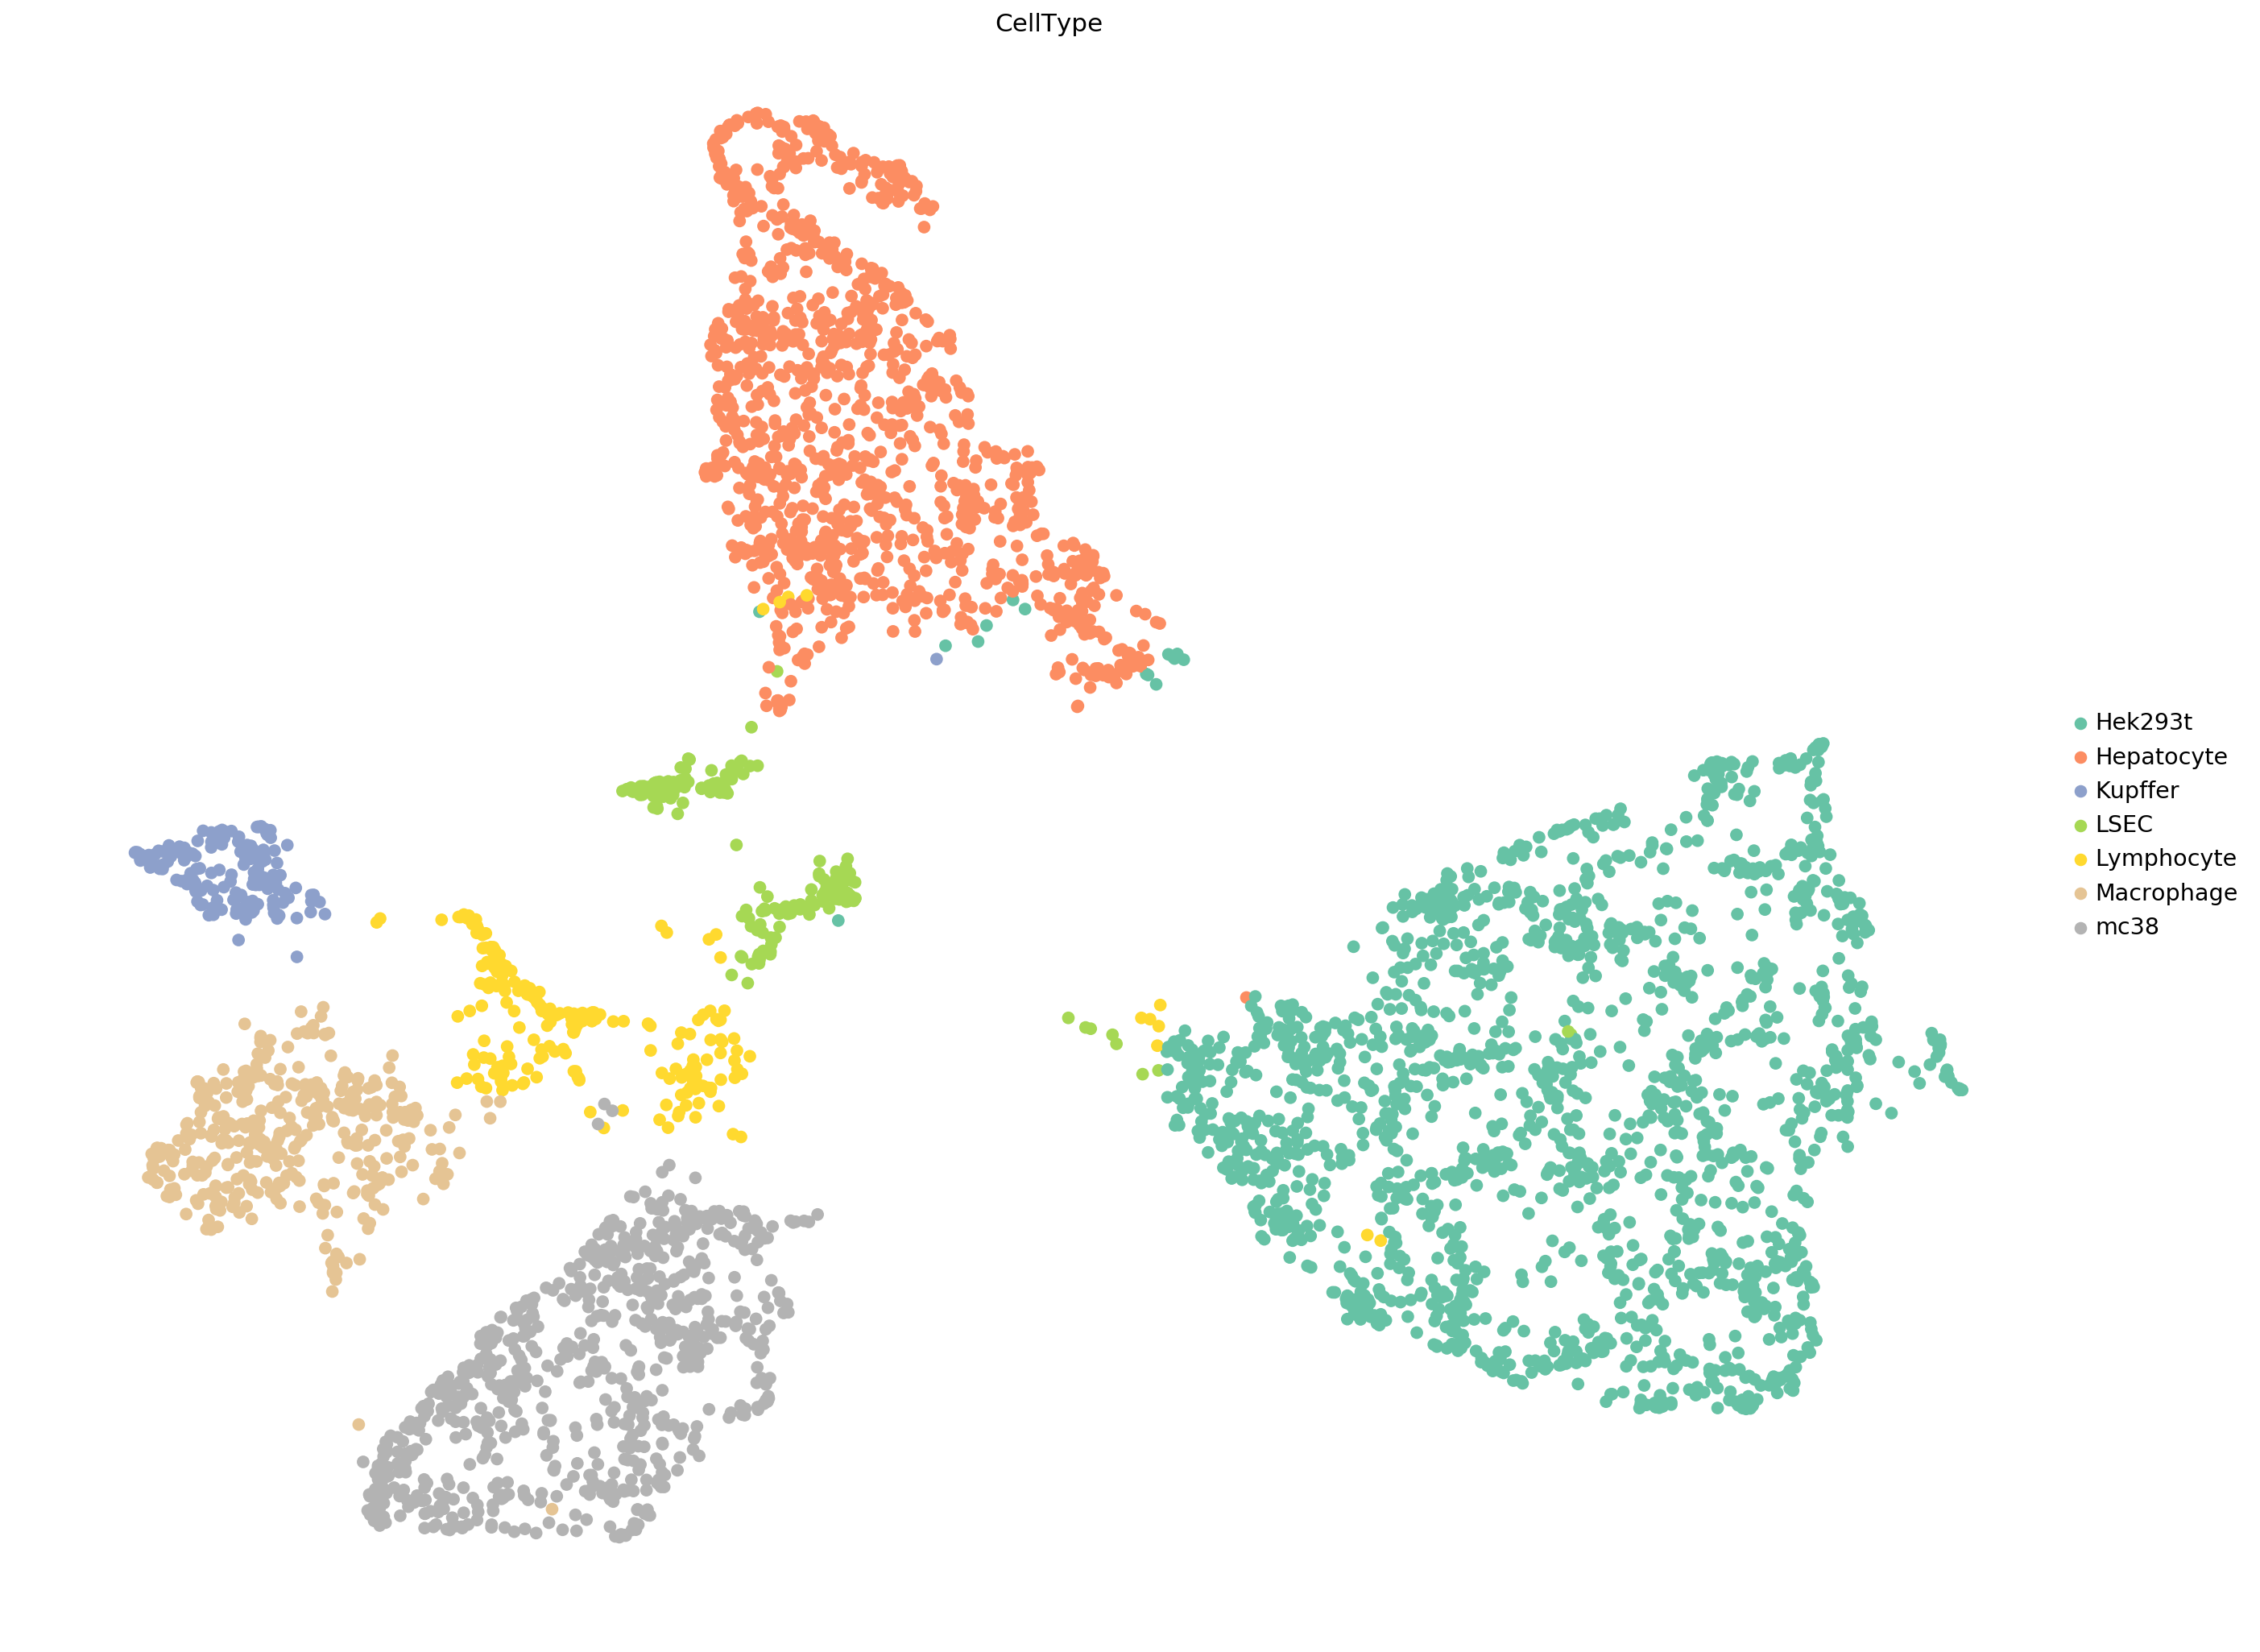

In [44]:
plt.rcParams['figure.figsize'] = [20, 16]

sc.pl.umap(adata, 
           color=['CellType'],
           ncols=1,
           palette="Set2",
           color_map=mpl.cm.CMRmap,
           frameon=False,
        #   legend_loc='on data',
        # save='test.svg',
           size=200,
          )




In [45]:
adata.uns['CellType_colors']

['#66c2a5', '#fc8d62', '#8da0cb', '#a6d854', '#ffd92f', '#e5c494', '#b3b3b3']

In [46]:
adata.uns['CellType_colors']=['#e41a1c',
                              '#377eb8',
                              '#984ea3',
                              '#ff7f00',
                              '#ffff33',
                              '#f781bf',
                              '#4daf4a']

In [47]:
from pylab import *

cmap = cm.get_cmap('Set1')    # PiYG

for i in range(cmap.N):
    rgb = cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
    print(matplotlib.colors.rgb2hex(rgb))

#e41a1c
#377eb8
#4daf4a
#984ea3
#ff7f00
#ffff33
#a65628
#f781bf
#999999


In [52]:
liver

x   y   area
0     4  10  liver
1     4  11  liver
2     4  12  liver
3     5   9  liver
4     5  10  liver
5     5  11  liver
6     5  12  liver
7     5  13  liver
8     5  14  liver
9     6   8  liver
10    6   9  liver
11    6  10  liver
12    6  11  liver
13    6  12  liver
14    6  13  liver
15    6  14  liver
16    6  15  liver
17    7   8  liver
18    7   9  liver
19    7  10  liver
20    7  11  liver
21    7  12  liver
22    7  13  liver
23    7  14  liver
24    7  15  liver
25    7  16  liver
26    7  17  liver
27    8   8  liver
28    8   9  liver
29    8  10  liver
..   ..  ..    ...
133  20  17  liver
134  21  10  liver
135  21  11  liver
136  21  15  liver
137  21  16  liver
138  21  17  liver
139  22  10  liver
140  22  11  liver
141  22  16  liver
142  23  10  liver
143  23  11  liver
144  23  16  liver
145  23  17  liver
146  24   9  liver
147  24  10  liver
148  24  16  liver
149  24  17  liver
150  25  10  liver
151  25  11  liver
152  25  17  liver
153  25  18  liver
154  26  10  liver
155  26  17  liver
156  27  11  liver
157  27  18  liver
158  28  10  liver
159  28  17  liver
160  29  11  liver
161  29  17  liver
162  30  17  liver

[163 rows x 3 columns]

In [54]:
tumor=pd.read_csv("../../../XYZeq/L20C1_tumor_wells.csv")
liver=pd.read_csv("../../../XYZeq/L20C1_liver_wells.csv")

liver.columns=['X','Y']
tumor.columns=['X','Y']

liver['area']='liver'
tumor['area']='tumor'

liver['coordinate']=liver['X'].map(str)+','+liver['Y'].map(str)
liver=liver.drop(['X','Y'],axis=1)

tumor['coordinate']=tumor['X'].map(str)+','+tumor['Y'].map(str)
tumor=tumor.drop(['X','Y'],axis=1)

In [55]:
tissue_type=pd.concat([liver,tumor])
tissue_type=tissue_type.reset_index(drop=True)

In [56]:
plate_map='../../../XYZeq/data/20181219_species_exp/plate23_map.csv'
spatial_map=pd.read_csv(plate_map, header=None, names=['barcode', 'X', 'Y'])

spatial_map['coordinate']=spatial_map['X'].map(str)+','+spatial_map['Y'].map(str)
tissue_type_map=spatial_map.drop(['X','Y'],axis=1)

In [57]:
tissue_type=tissue_type_map.merge(tissue_type,on=['coordinate'], how='left')

tissue_type=tissue_type.fillna('none')

tissue_type=tissue_type.drop(['coordinate'],axis=1)

In [58]:

df=pd.DataFrame(adata.obs.CellType)
df['barcode']=df.index.str[-16:]

In [59]:
adata.obs['barcode']=df['barcode']

In [60]:
ref=pd.DataFrame(adata.obs['barcode'])
tissue_type=ref.merge(tissue_type, on='barcode',how='left')#.reindex(adata.obs_names)

tissue_type.index=adata.obs_names
tissue_type=tissue_type.drop('barcode',axis=1)

adata.obs['area_1']=tissue_type

In [61]:
adata

AnnData object with n_obs × n_vars = 4788 × 789 
    obs: 'n_counts', 'n_genes', 'percent_mito', 'leiden', 'louvain', 'CellType', 'barcode', 'area_1'
    var: 'n_cells'
    uns: 'pca', 'neighbors', 'leiden', 'louvain', 'leiden_colors', 'CellType_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

... storing 'barcode' as categorical
... storing 'area_1' as categorical


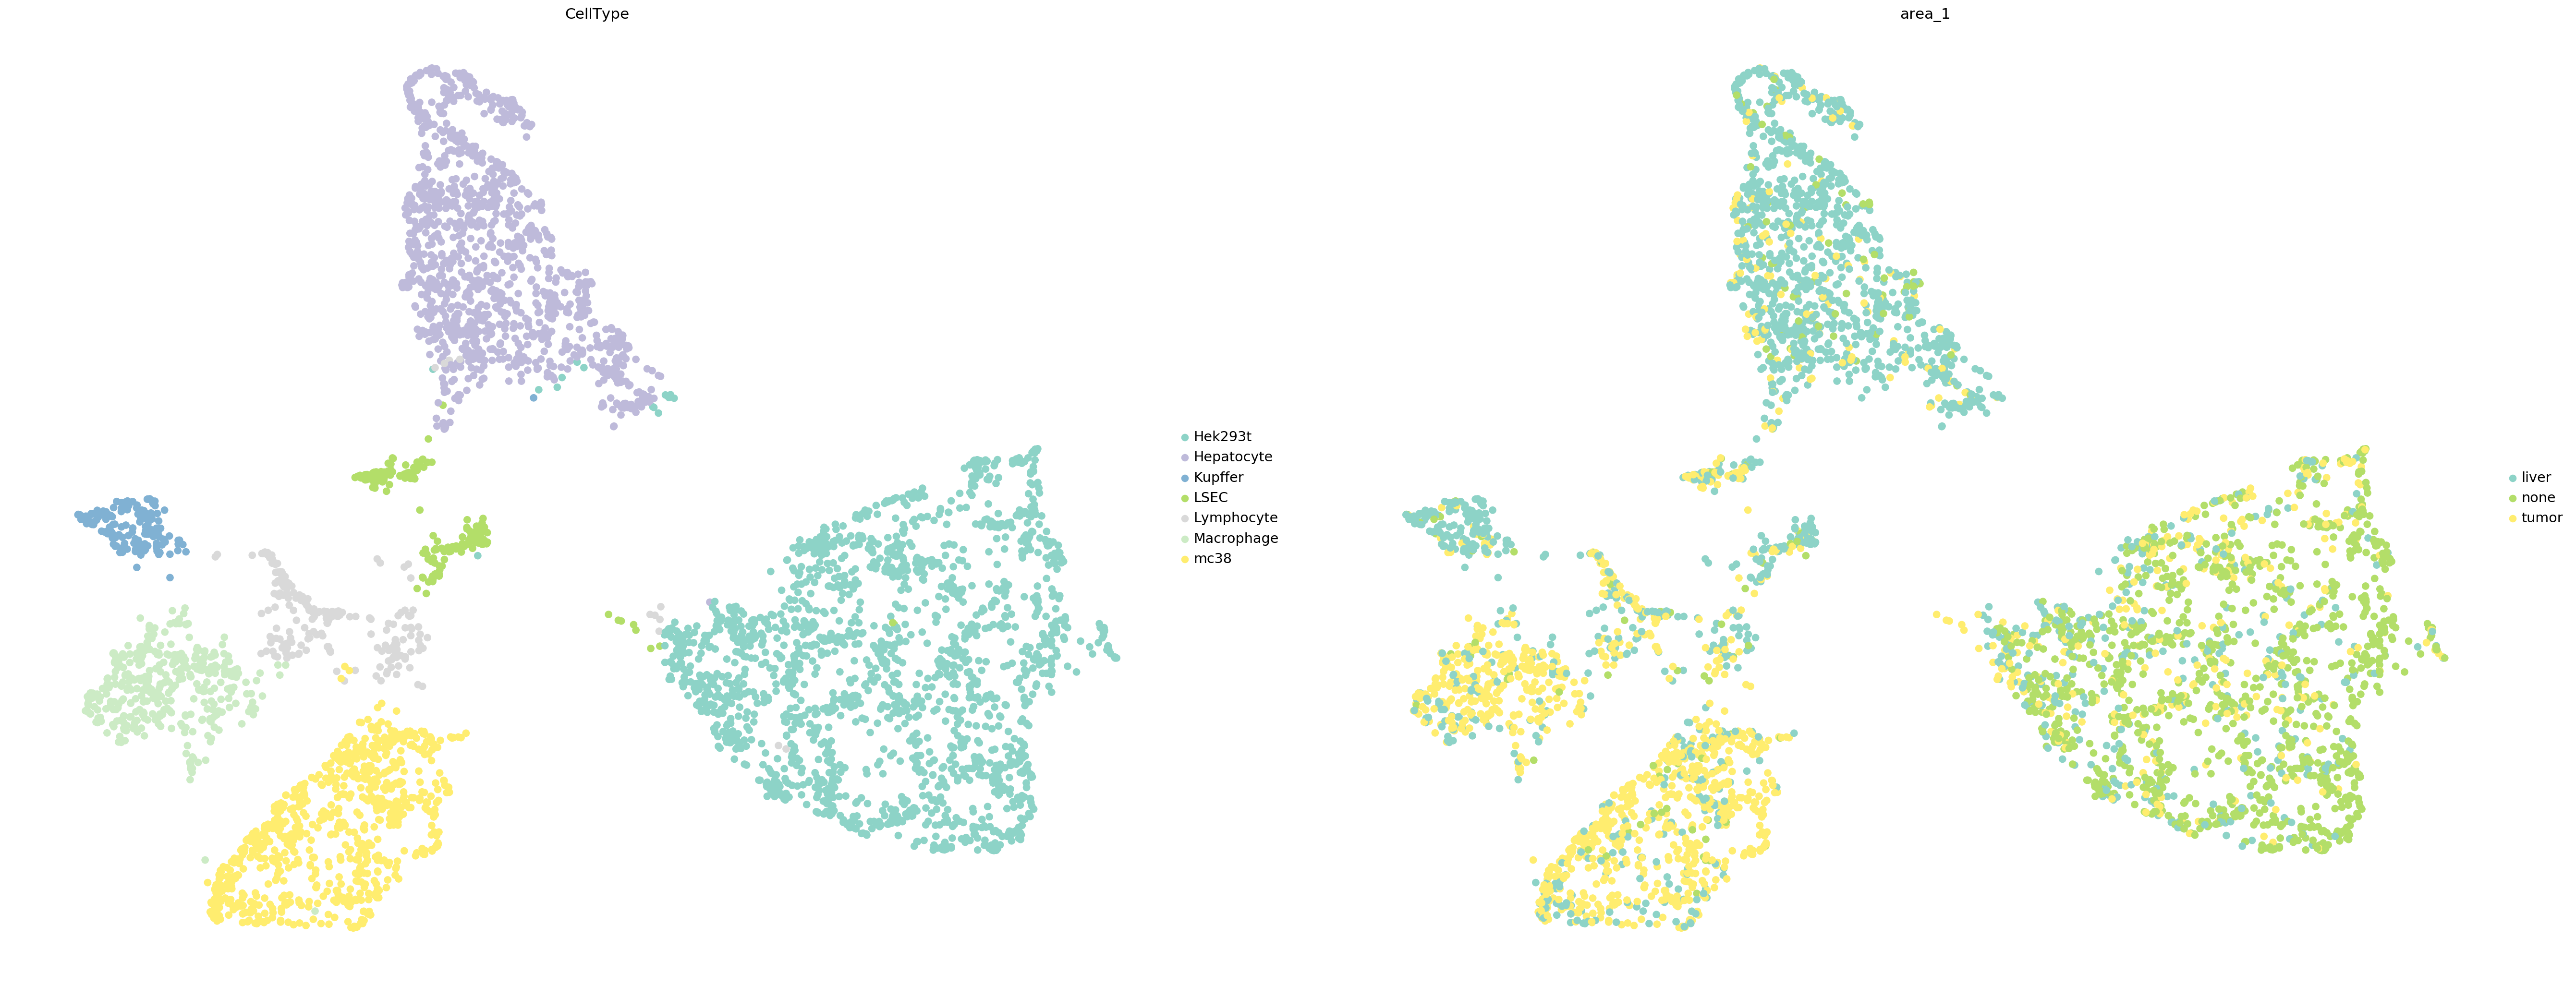

In [62]:
plt.rcParams['figure.figsize'] = [20, 16]

sc.pl.umap(adata, 
           color=['CellType','area_1'],
           ncols=2,
           palette="Set3",
           color_map=mpl.cm.CMRmap,
           frameon=False,
        #   legend_loc='on data',
        # save='test.svg',
           size=200,
          )


In [63]:
adata_Lymphocyte=adata[adata.obs['CellType']=='Lymphocyte']
adata_Macrophage=adata[adata.obs['CellType']=='Macrophage']
adata_Hepatocyte=adata[adata.obs['CellType']=='Hepatocyte']


In [ ]:
sc.tl.rank_genes_groups(adata_Lymphocyte, 
                        'area_1',
                       )

sc.pl.rank_genes_groups(adata_Lymphocyte, 
                        n_genes=40, 
                 #       groups=[str(3)],
                        ncols=1,
                        fontsize=20,
                        sharey=False
                       )

In [ ]:
sc.tl.rank_genes_groups(adata_Macrophage, 
                        'area_1',
                       )

sc.pl.rank_genes_groups(adata_Macrophage, 
                        n_genes=40, 
                 #       groups=[str(3)],
                        ncols=1,
                        fontsize=20,
                        sharey=False
                       )

In [ ]:
sc.tl.rank_genes_groups(adata_Hepatocyte, 
                        'area_1',
                       )

sc.pl.rank_genes_groups(adata_Hepatocyte, 
                        n_genes=40, 
                 #       groups=[str(3)],
                        ncols=1,
                        fontsize=20,
                        sharey=False
                       )

In [64]:
plate_map='../../../XYZeq/data/20181219_species_exp/plate23_map.csv'
spatial_map=pd.read_csv(plate_map, header=None, names=['barcode', 'X', 'Y'])

In [65]:
cutoff=0

In [66]:
def hexagon(x, y, c='k'):
	from matplotlib.patches import Polygon

	points = [[x + (2/3), y],
			  [x + (1/3), y + 0.5],
   			  [x - (1/3), y + 0.5],
              [x - (2/3), y],
   			  [x - (1/3), y - 0.5],
   			  [x + (1/3), y - 0.5]]
    
	polygon = Polygon(points, edgecolor='w', fc=c)
	return polygon

In [67]:
df=pd.DataFrame(adata.obs.area_1)



In [68]:
df['barcode']=df.index.str[-16:]

/Users/derekbogdanoff/projects/venv3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


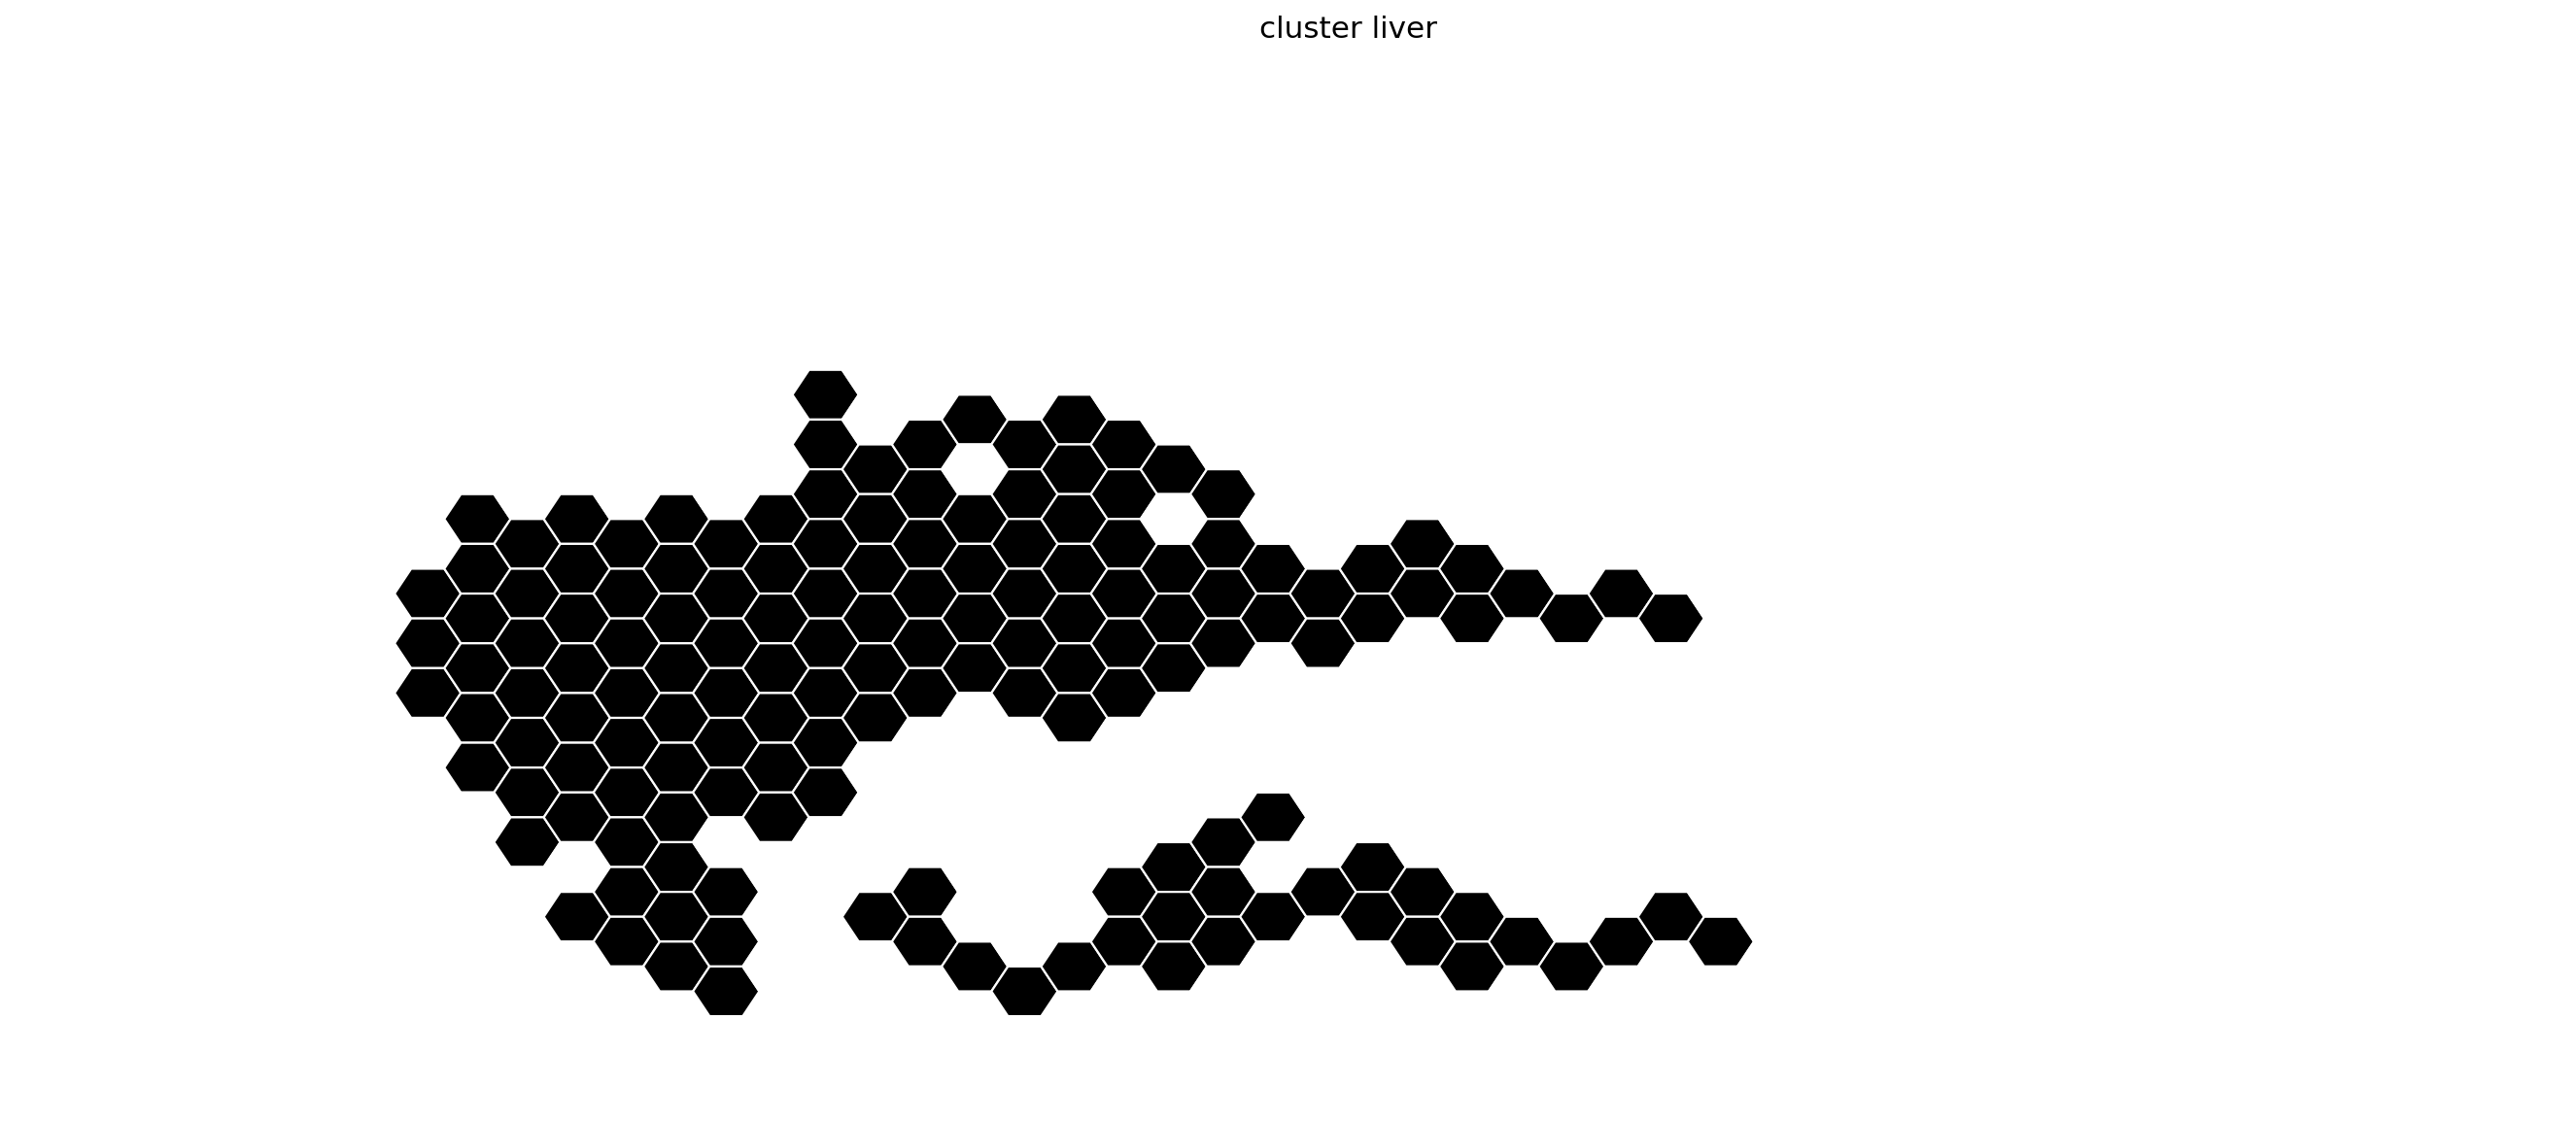

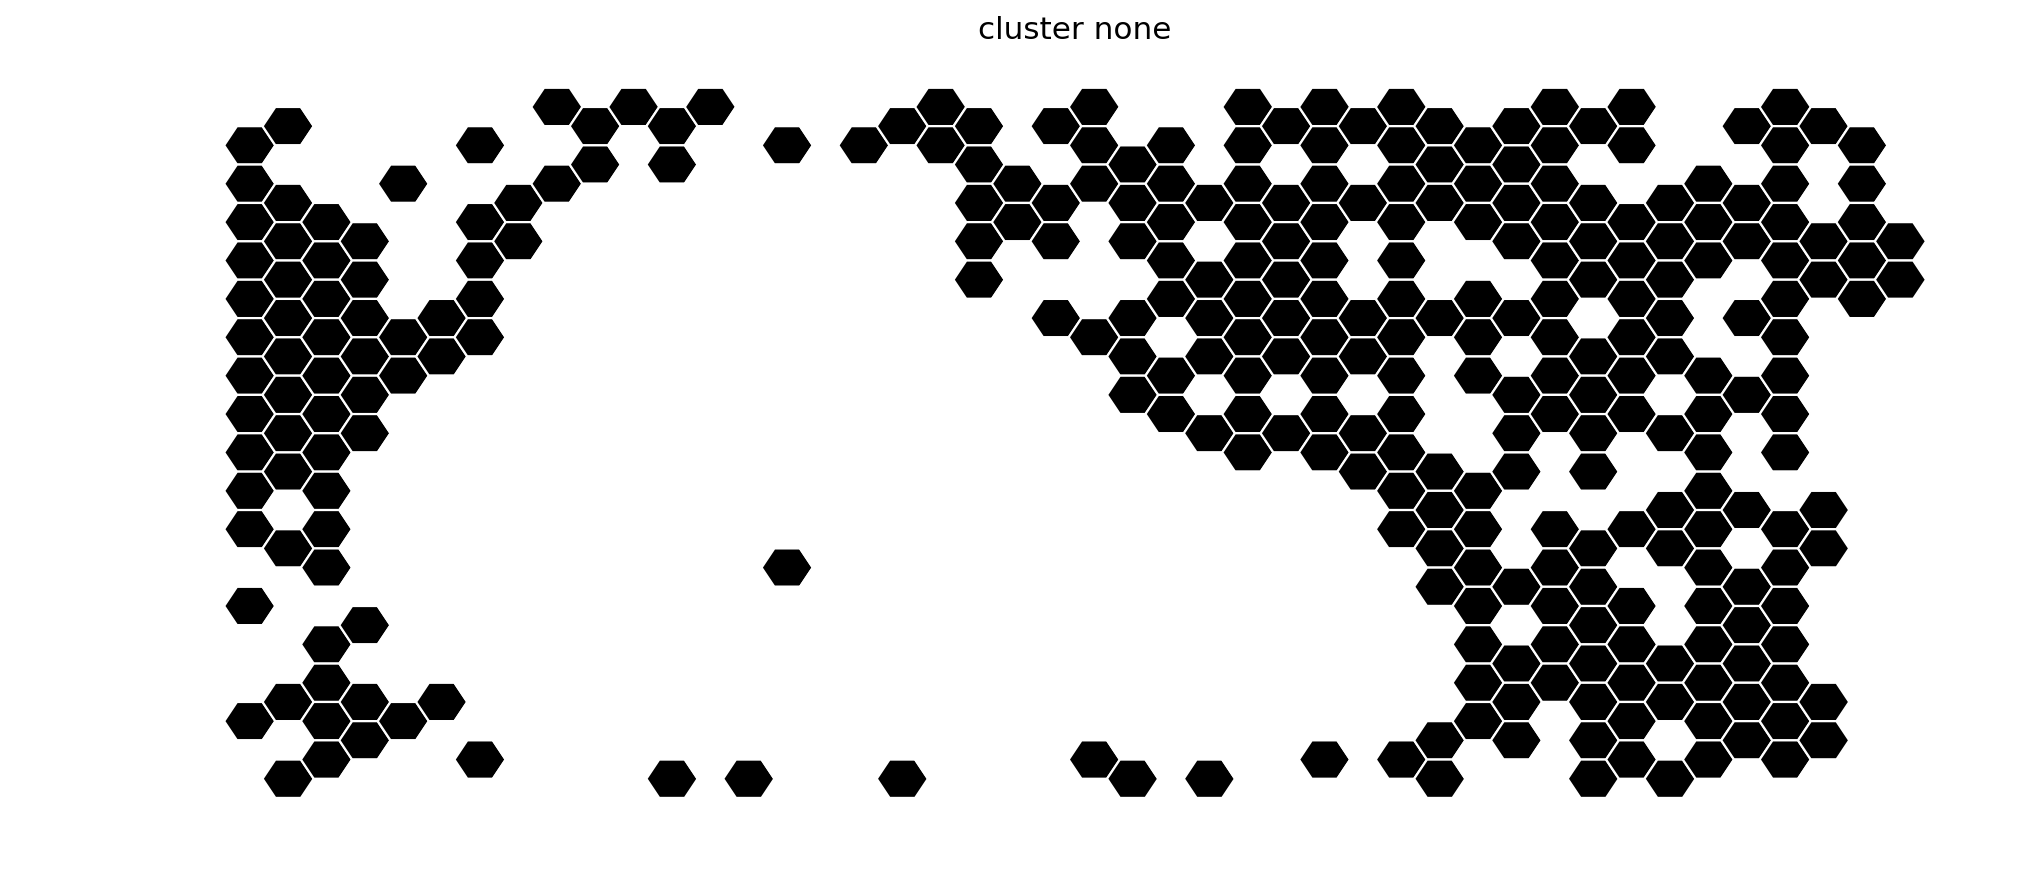

In [69]:

color_itorator=0



for t in adata.obs.area_1.cat.categories:
#for t in ['1']:
    df_=df[df['area_1'] == t]
    
    #sets cell counter
    df_['count']=1
    
    df__=df_.groupby('barcode', as_index=False)['count'].sum()

    map_array=spatial_map.merge(df__, on='barcode', how='left')
    
    map_array=map_array.fillna('0')
    map_array['count']=map_array['count'].astype(int)
    
    
    
    # max value for coloring
    max_val=max(map_array['count'])
    norm = mpl.colors.Normalize(vmin=0,vmax=max_val)
    
    custom_color=adata.uns['CellType_colors'][color_itorator]
    custom_map = mpl.colors.LinearSegmentedColormap.from_list("", ["#ffffff",custom_color])
    
    color_itorator = color_itorator+1
    
    count_hex=[]
    for i in map_array['count']:
        if i > cutoff:

        #    count_hex.append(mpl.colors.rgb2hex(custom_map(norm(i))[:3]))
            count_hex.append('#000000')
            
        else:
            count_hex.append('#ffffff')

    map_array['color']=count_hex
    
    for index, row in map_array.iterrows():
        if row['X'] % 2 != 0:
            row['Y']=row['Y']-0.5
    
        polygon = hexagon(row['X'],row['Y'],row['color'])
        plt.gca().add_patch(polygon)
    
  
    plt.ylim(18,0) #flip y axis
    plt.axis('scaled')
    plt.rcParams['figure.figsize'] = [15, 7.5] 
    
    plt.ylabel('cell number')
    plt.title('cluster %s' %t) 
    plt.axis('off')

    
    
    
    
#fix this here...
 #   mesh = plt.pcolormesh(pd.DataFrame(map_array['count']), cmap=custom_map)
 #   plt.colorbar(mesh)
    
 #   plt.savefig('/Users/derekbogdanoff/Desktop/test.svg', bbox_inches='tight')
    plt.show()

In [109]:
# plt.rcParams['figure.figsize'] = [20, 16]

# from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox

# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg


# import scipy.misc
# from scipy import ndimage
# import matplotlib.pyplot as plt








# fig, ax = plt.subplots()

# # ax.set_xlim(0, 1)
# # ax.set_ylim(0, 1)

arr_image = mpimg.imread('/Users/derekbogdanoff/Desktop/h_and_e_liver.jpg')


imagebox = OffsetImage(arr_image, zoom=2.2)
type(imagebox)
# ab = AnnotationBbox(imagebox, (0.6, 0.6))

# ax.add_artist(ab)














# plt.grid()

# plt.draw()
# #plt.savefig('add_picture_matplotlib_figure.png',bbox_inches='tight')
# plt.show()

matplotlib.offsetbox.OffsetImage

In [108]:
import scipy.misc
from scipy import ndimage
import matplotlib.pyplot as plt

#img = scipy.misc.lena()  
img =  mpimg.imread('/Users/derekbogdanoff/Desktop/h_and_e_liver.jpg') #scipy.misc.face()  # lena is not included in scipy 0.19.1

tr = scipy.ndimage.rotate(img,5,cval=255)
imshow(tr)


